<a href="https://colab.research.google.com/github/tbarton16/Autoencoders/blob/main/autoencoder_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders: Vanilla and Variational
In this notebook, we will code up a vanilla autoencoder and then a varational autoencoder to generate MNIST images.

In [64]:
import collections
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import pdb

## Hyperparameters

In [65]:
lr = 1e-3
bsz = 10
device =  torch.device('cuda')
epochs = 10

## Download MNIST Data

In [40]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
 # torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.MNIST('../data', train=False, transform=transform)

dataloader_train = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size = bsz)
dataloader_val = torch.utils.data.DataLoader(validation_dataset, shuffle=True, batch_size = bsz)

## Create architecture for AE

In [4]:
class Encoder(torch.nn.Module):
  """Take image tensors and encode into low-dim"""
  def __init__(self, n_code):
    """ Architexture: convolution layers (2) (4x4) 
                      fc layers (2) 
                      output layer needs to be n_code
    """
    super().__init__()
    self.n_code = n_code
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4) # input (bsz, 1, 28, 28) -> (bsz, 10, 25, 25)
    # [(W−K+2P)/S]+1 = (28 - 4 +  ) / 1  + 1 = 25
    # 25 - 4 + 0 /1 + 1 = 22
    self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=10, kernel_size=4) # output =(bsz, 10, 22, 22)
    self.lin1 = torch.nn.Linear(10* 22 * 22, 256)
    self.lin2 = torch.nn.Linear(256, self.n_code)

  def forward(self, x):
    first_layer = F.relu(self.conv1(x))
    second_layer = F.relu(self.conv2(first_layer))# (bsz, 10, 22, 22)
    second_layer_flat = second_layer.reshape((second_layer.shape[0], -1))
    fc_1 = F.relu(self.lin1(second_layer_flat))
    code = self.lin2(fc_1)

    return code

x = torch.randn(10, 1, 28, 28)
tessnet = Encoder(10)
print(tessnet(x).shape)

torch.Size([10, 10])


In [5]:
class Decoder(torch.nn.Module):
  """Input low-dim z and output image"""
  def __init__(self, n_code):
    """Architecture:
        1 fc layer bsz, n_code -> bsz, 256 16x16 
        [(W−K+2P)/S]+1 = 20 - k  =15
        (28 − K) = 19
        up-conv -> (bsz, 1, 20, 20)
        output layer needs to be (bsz, 1, 28, 28)
    """
    super().__init__()
    self.n_code = n_code
    self.fc1 = torch.nn.Linear(n_code, 256)
    self.relu1 = torch.nn.ReLU()
    self.deconv1 = torch.nn.ConvTranspose2d(1, 2, kernel_size=5)
    self.relu2 = torch.nn.ReLU()
    self.deconv2 = torch.nn.ConvTranspose2d(2, 1, kernel_size=9)

  def forward(self, x):
    fc1_output = self.fc1(x) 
    new_dim = int(np.sqrt(fc1_output.shape[1]))
    fc1_square = fc1_output.reshape(fc1_output.shape[0], 1, new_dim, new_dim)
    deconv1 = self.deconv1(self.relu1(fc1_square))
    deconv2 = self.deconv2(self.relu2(deconv1))
    return deconv2

x = torch.randn(10, 10)
d = Decoder(10)
print(d(x).shape) 

torch.Size([10, 1, 28, 28])


In [6]:
class AutoEncoder(torch.nn.Module):
  """Input a image, output an image
  """
  def __init__(self, n_dim):
    super().__init__()
    self.encoder = Encoder(n_dim)
    self.decoder = Decoder(n_dim)
  
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def predict(self, x):
    self.eval()
    with torch.no_grad():
      y = self.forward(x)
    return y

x = torch.randn(10, 1, 28, 28)
tessnet = AutoEncoder(10)
print(tessnet(x).shape)

torch.Size([10, 1, 28, 28])


## Loss function for AE

In [7]:
#criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()

## Training Loop for AE

In [8]:
tessnet = AutoEncoder(10).to(device)
optimizer = torch.optim.Adam(tessnet.parameters(), lr=lr)

for e in range(epochs):
  for i, batch in enumerate(dataloader_train):
    x, _ = batch
    x = x.to(device)
    pred = tessnet(x)
    loss = criterion(pred, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 400 == 0:
      print(f"Epoch: {e} iter: {i} loss: {loss.item() }")



Epoch: 0 iter: 0 loss: 0.6992746591567993
Epoch: 0 iter: 400 loss: 0.5310486555099487
Epoch: 0 iter: 800 loss: 0.4564155042171478


KeyboardInterrupt: ignored

## Architecture for VAE

In [54]:
class VAE(torch.nn.Module):
  """Input is image, output is: 
     a) Mean  mu(z|x) -> (bsz, z_dim)
     b) Sample z (bsz, z_dim) from latent space from Normal gaussian with mean mu and sigma z_dim, z_dim
     c) Run decoder on sample get new mu
     d) mse on generated and input
  """
  def __init__(self, n_code, device):
    """Architecture: encoder decoder
    """
    super().__init__()
    self.encoder = Encoder(n_code)
    self.decoder = Decoder(n_code)
    self.fcmu = torch.nn.Linear(n_code, n_code)
    self.fcsigma = torch.nn.Linear(n_code, n_code)
    self.device = device

  def reparametrize(self, mu, log_sigma):
    sigma = torch.exp(0.5 * log_sigma)
    noise = torch.randn_like(sigma).to(self.device)
    return mu + sigma*noise

  def forward(self, x):
    encoded = self.encoder(x) # estimate of mean
    relu_encoded = F.relu(encoded)

    mu = self.fcmu(relu_encoded)
    log_sigma = self.fcsigma(relu_encoded)

    reparam = self.reparametrize(mu, log_sigma)
    decoded = self.decoder(reparam)
    normed = torch.sigmoid(decoded)
    return normed, mu, log_sigma

  def pred(self,x):
    self.eval()
    with torch.no_grad():
      return self.forward(x)

device = torch.device('cpu')
x = torch.randn(bsz, 1, 28, 28)
d = VAE(10, device=device)
print(d(x)[0].shape) 
print(d(x)[1].shape)
print(d(x)[2].shape) 

torch.Size([10, 1, 28, 28])
torch.Size([10, 10])
torch.Size([10, 10])


## Loss function for VAE

In [59]:
def loss(pred, mu, log_sigma, input, kl_coeff):
  """Reconstruction loss + KL divergence"""
  KLD = kl_coeff * (-0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp()))
  Recon = F.binary_cross_entropy(pred, input)
  return Recon + KLD

## Training Loop for VAE

In [86]:

train_dict = collections.defaultdict(list)
test_dict = collections.defaultdict(list)
epochs = 5
for sweep in np.arange(.1,.9,.1):
  vae = VAE(128, device=device).to(device)
  opt = torch.optim.Adam(vae.parameters(), lr=lr)
  vae.train() 
  for e in range(epochs):
    l_train = []
    l_val = []
    for batch_idx, (data, _) in enumerate(dataloader_train):
      data = data.to(device)
      
      pred, mu, logsigma = vae(data)
      l = loss(pred, mu, logsigma, data)

      opt.zero_grad()
      l.backward()
      opt.step()

      l_train.append(l.item())
    for batch_idx, (data, _) in enumerate(dataloader_val):
      data = data.to(device)
      out, mu, log_sigma  = vae.pred(data)
      l = loss(out, mu, log_sigma, data)
      l_val.append(l.item())
    print(f"Sweep: {sweep} Epoch: {e}, train, {sum(l_train)}, val {sum(l_val)}")

    train_dict[sweep] += l_train
    test_dict[sweep] += l_val


Sweep: 0.1 Epoch: 0, train, 1052.2823958843946, val 132.39244478940964
Sweep: 0.1 Epoch: 1, train, 758.6629941686988, val 119.16123063862324
Sweep: 0.1 Epoch: 2, train, 700.3832067027688, val 112.39919980615377
Sweep: 0.1 Epoch: 3, train, 670.3438674807549, val 107.9365866035223
Sweep: 0.1 Epoch: 4, train, 652.1701605170965, val 105.90402025729418
Sweep: 0.2 Epoch: 0, train, 1133.0551175624132, val 142.7015279829502
Sweep: 0.2 Epoch: 1, train, 806.90037278831, val 125.6901871189475
Sweep: 0.2 Epoch: 2, train, 735.3560212999582, val 116.63684186339378
Sweep: 0.2 Epoch: 3, train, 689.9656659513712, val 111.33668833971024
Sweep: 0.2 Epoch: 4, train, 658.6668943092227, val 105.97896807640791
Sweep: 0.30000000000000004 Epoch: 0, train, 1123.9906703680754, val 141.05116266012192
Sweep: 0.30000000000000004 Epoch: 1, train, 773.0431642085314, val 117.26876205950975
Sweep: 0.30000000000000004 Epoch: 2, train, 701.2904849126935, val 112.53767513483763
Sweep: 0.30000000000000004 Epoch: 3, train, 

Text(0.5, 1.0, 'test')

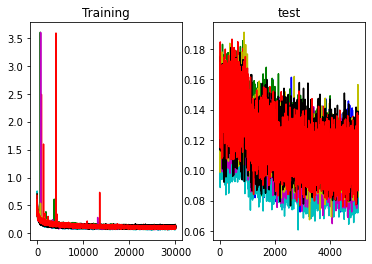

In [87]:
import matplotlib.pyplot as plt
from cycler import cycler
custom_cycler = (cycler(color=['b','g', 'r','c', 'm', 'y', 'k', 'r']))
plt.rc('axes', prop_cycle=custom_cycler)
fig, (ax0, ax1) = plt.subplots(ncols=2)

for t in train_dict.keys():
  #print(t)
  ax0.plot(train_dict[t])
ax0.set_title("Training")

for t in test_dict.keys():
  ax1.plot(test_dict[t])
ax1.set_title("test")

## Compare generations from AE vs VAE

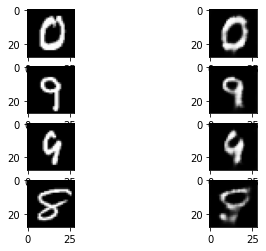

In [88]:
img, bleh = next(iter(dataloader_train))
output,mu,sig = vae.pred(img.to(device))

img.to(torch.device('cpu'))
output = output.cpu()
dim = (4,2)
fig, axs = plt.subplots(*dim)
for row in range(dim[0]):
  axs[row, 0].imshow(img[row].reshape(28,28), cmap="gray")
  axs[row, 1].imshow(output[row].reshape(28,28), cmap="gray")

/usr/local/lib/python3.8/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


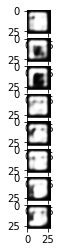

In [99]:
# sample 
N = torch.distributions.Normal(0,1)
outputs = []
for i in range(8):
  z = N.sample_n(128).to(device)
  z = z.unsqueeze(0)
  vae.eval()

  with torch.no_grad():
    output = torch.sigmoid(vae.decoder(z))
  outputs.append(output)
  

dim = (8,1)
fig, axs = plt.subplots(*dim)
for row in range(dim[0]):
  o = outputs[row].cpu()
  axs[row].imshow(o.reshape(28,28), cmap="gray")
